# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [10]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

from tqdm import tqdm, tqdm_notebook
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import math
import spacy
import torch
import transformers

import warnings
warnings.filterwarnings("ignore")

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8')
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

In [12]:
# plt.style.available

In [13]:
#Load Data
try:
    df_reviews = pd.read_csv('\imdb_reviews.tsv', sep='\t')
except:
    df_reviews = pd.read_csv('https://code.s3.yandex.net/datasets/imdb_reviews.tsv', sep='\t')
      

In [14]:
#Preview DataFrame sample.
display(df_reviews.head())

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


The dataframe we will be working with has 18 columns, including categorical discrete, and continiours variables. Since we are building a model to predict whether a review is positive or negative based solely on its content, most of these features are irrelevant. Therefore, we only need to preprocess the 'review' and 'pos' Series for our model.

In [15]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [16]:
#Calculate total rows with missing values in 'review' or 'pos' column.
print("Total NaNs in each column: ")
display(df_reviews.isnull().sum())

Total NaNs in each column: 


tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

It appears that there are only NAns in the 'average_rating' and 'votes' columns. Since we won't be using these columns in developing a sentiment analyzer for reviews, we won't address the Nans.

In [17]:
#Print total number of duplicated rows.
print(f'Total duplicated rows: {df_reviews.duplicated().sum()}')

Total duplicated rows: 0


In [18]:
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

In [19]:
#Create function to remove all but letters and apostrophes from 'review' column.
def reduce_char(df):
    """
    Function removes all but letters and apostrophes from texts.
    """
    reduced = re.sub(r"[^a-zA-Z']", " ", df).split()
    reduced = " ".join(reduced).lower()
    return reduced

#Apply function to every review in the DataFrame
df_reviews['rev_norm'] = df_reviews['review'].apply(reduce_char)

We need not worry about most columns in our Dataframe as our goal is to build a model that predicts whether a review is positive or negative based solely on its content. There are no duplicated or missing review/pos values. Both columns are formatted correctly, and all non-letter/apostrophe characters have been removed from the text.

## EDA

Let's check the number of movies and reviews over years.

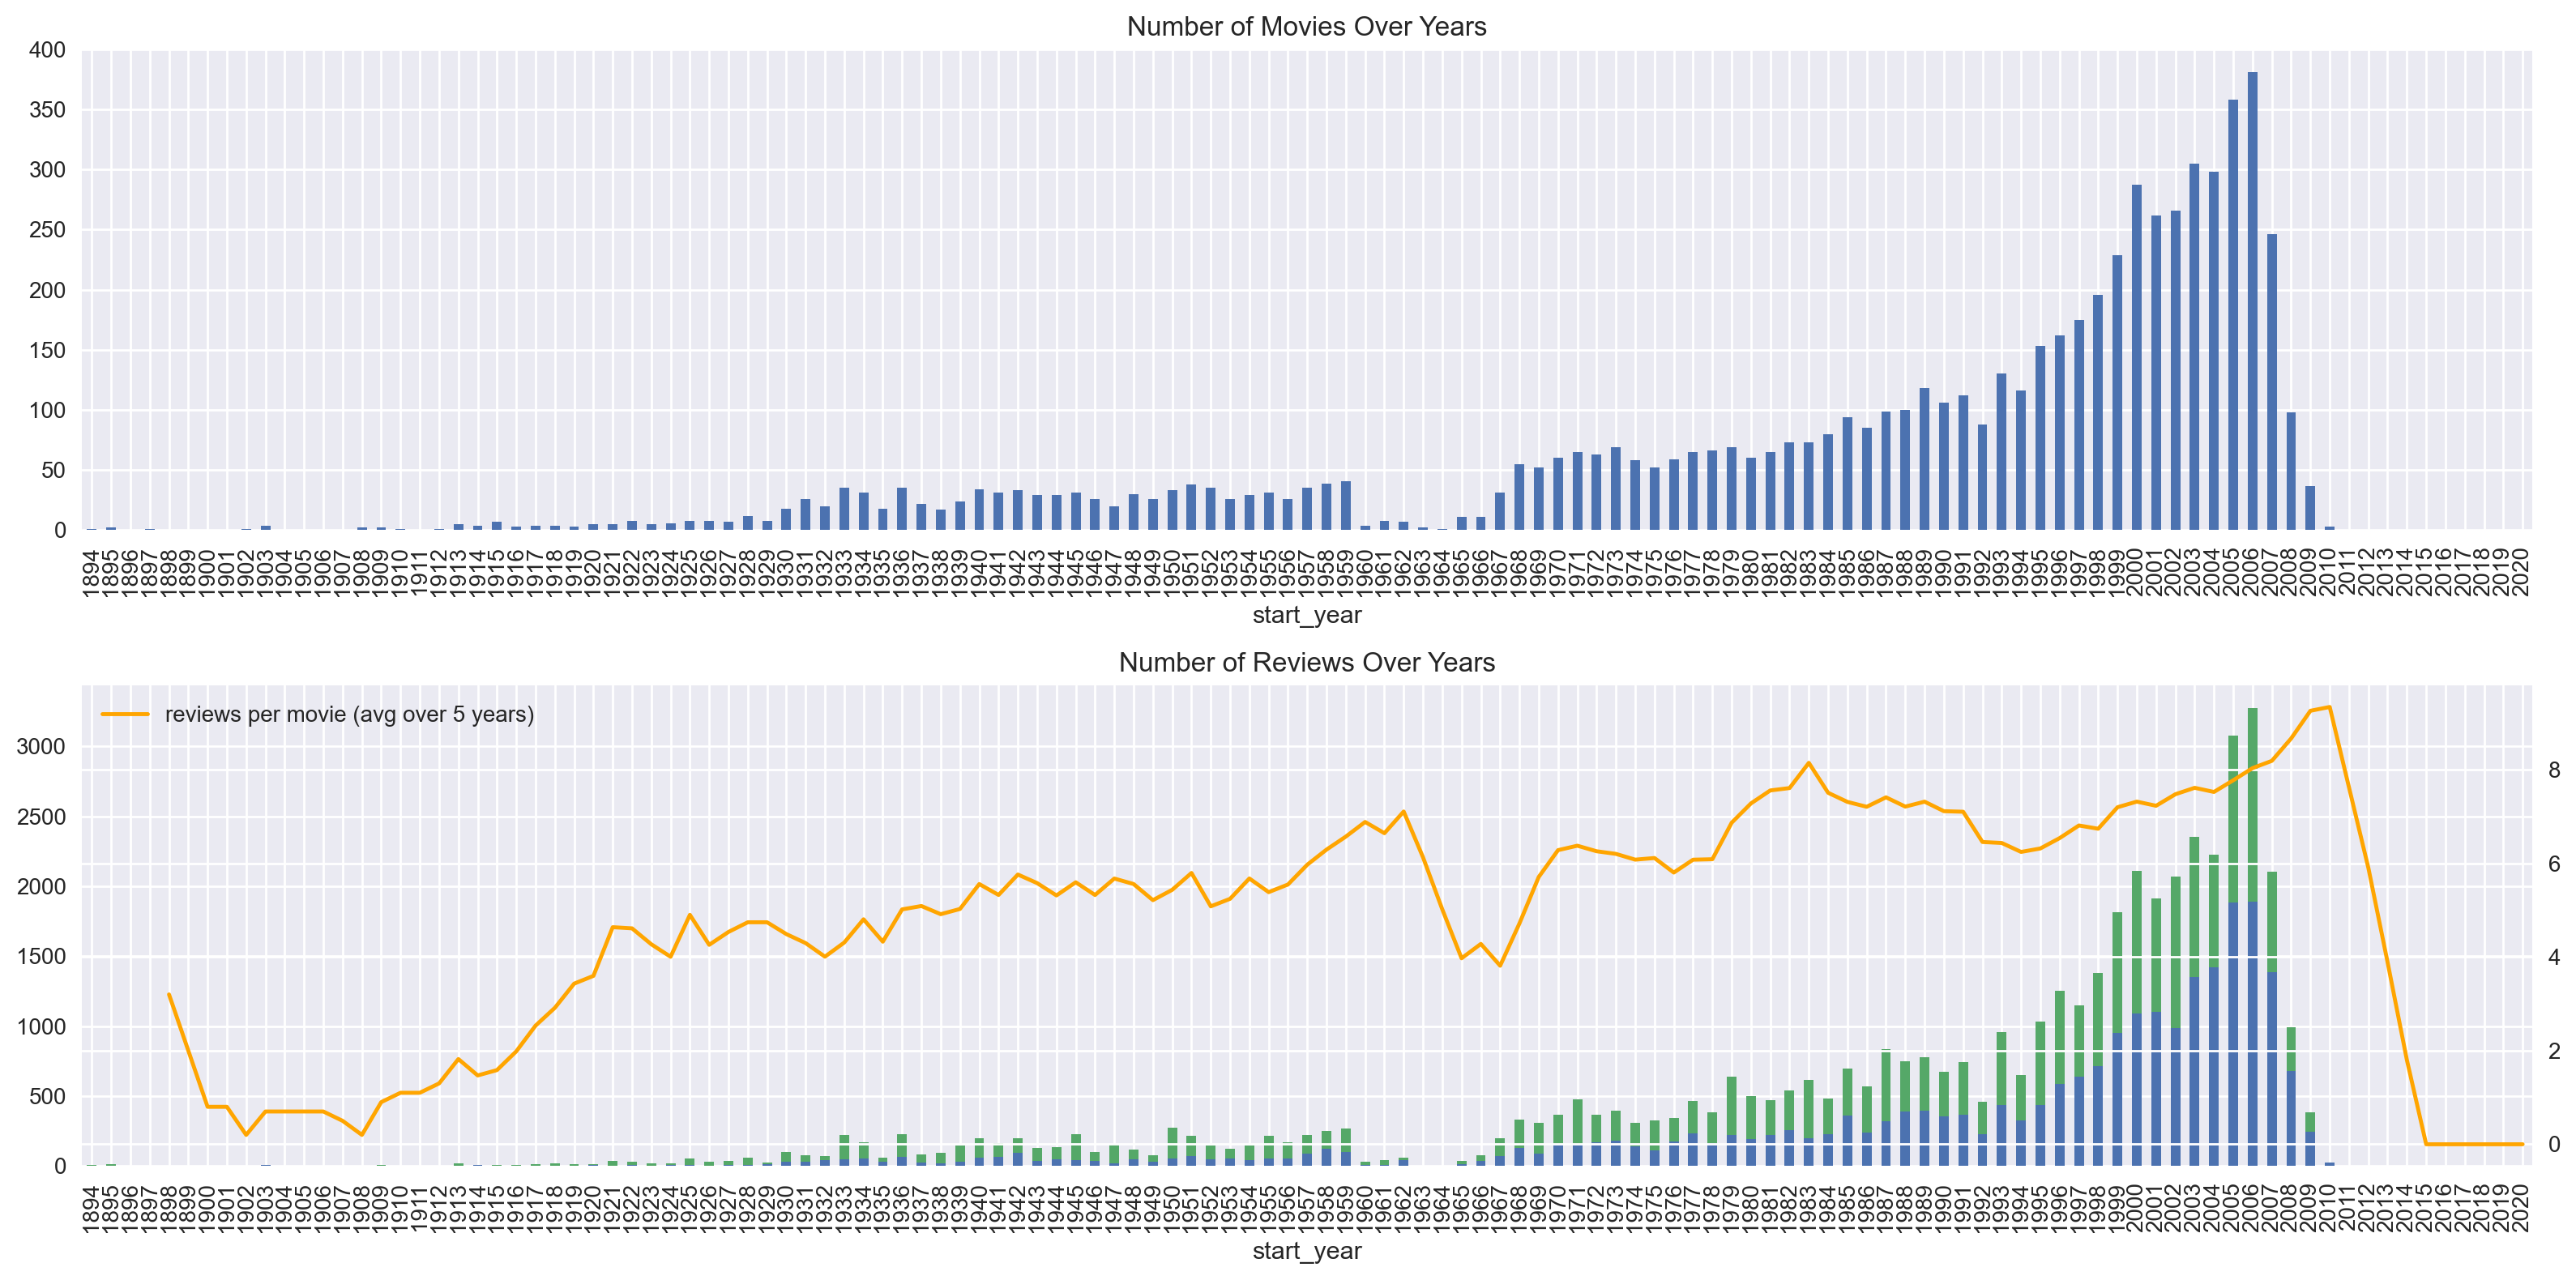

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

The Dataframe indicates that 2006 had the most movies released and reviews made. Movie releases declined after 2006, coinciding with the 2008 financial crisis; review numbers followed the same trend.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

We will plot the distribution of movie reviews by grouping movies and counting reviews for each. We'll plot the number of reviews on the x-axis and the total number of movies with that number of reviews on the y-axis. Then, we'll count the total number of reviews for each movei and plot the frequency of movies with each number of reviews using a KDE plot.

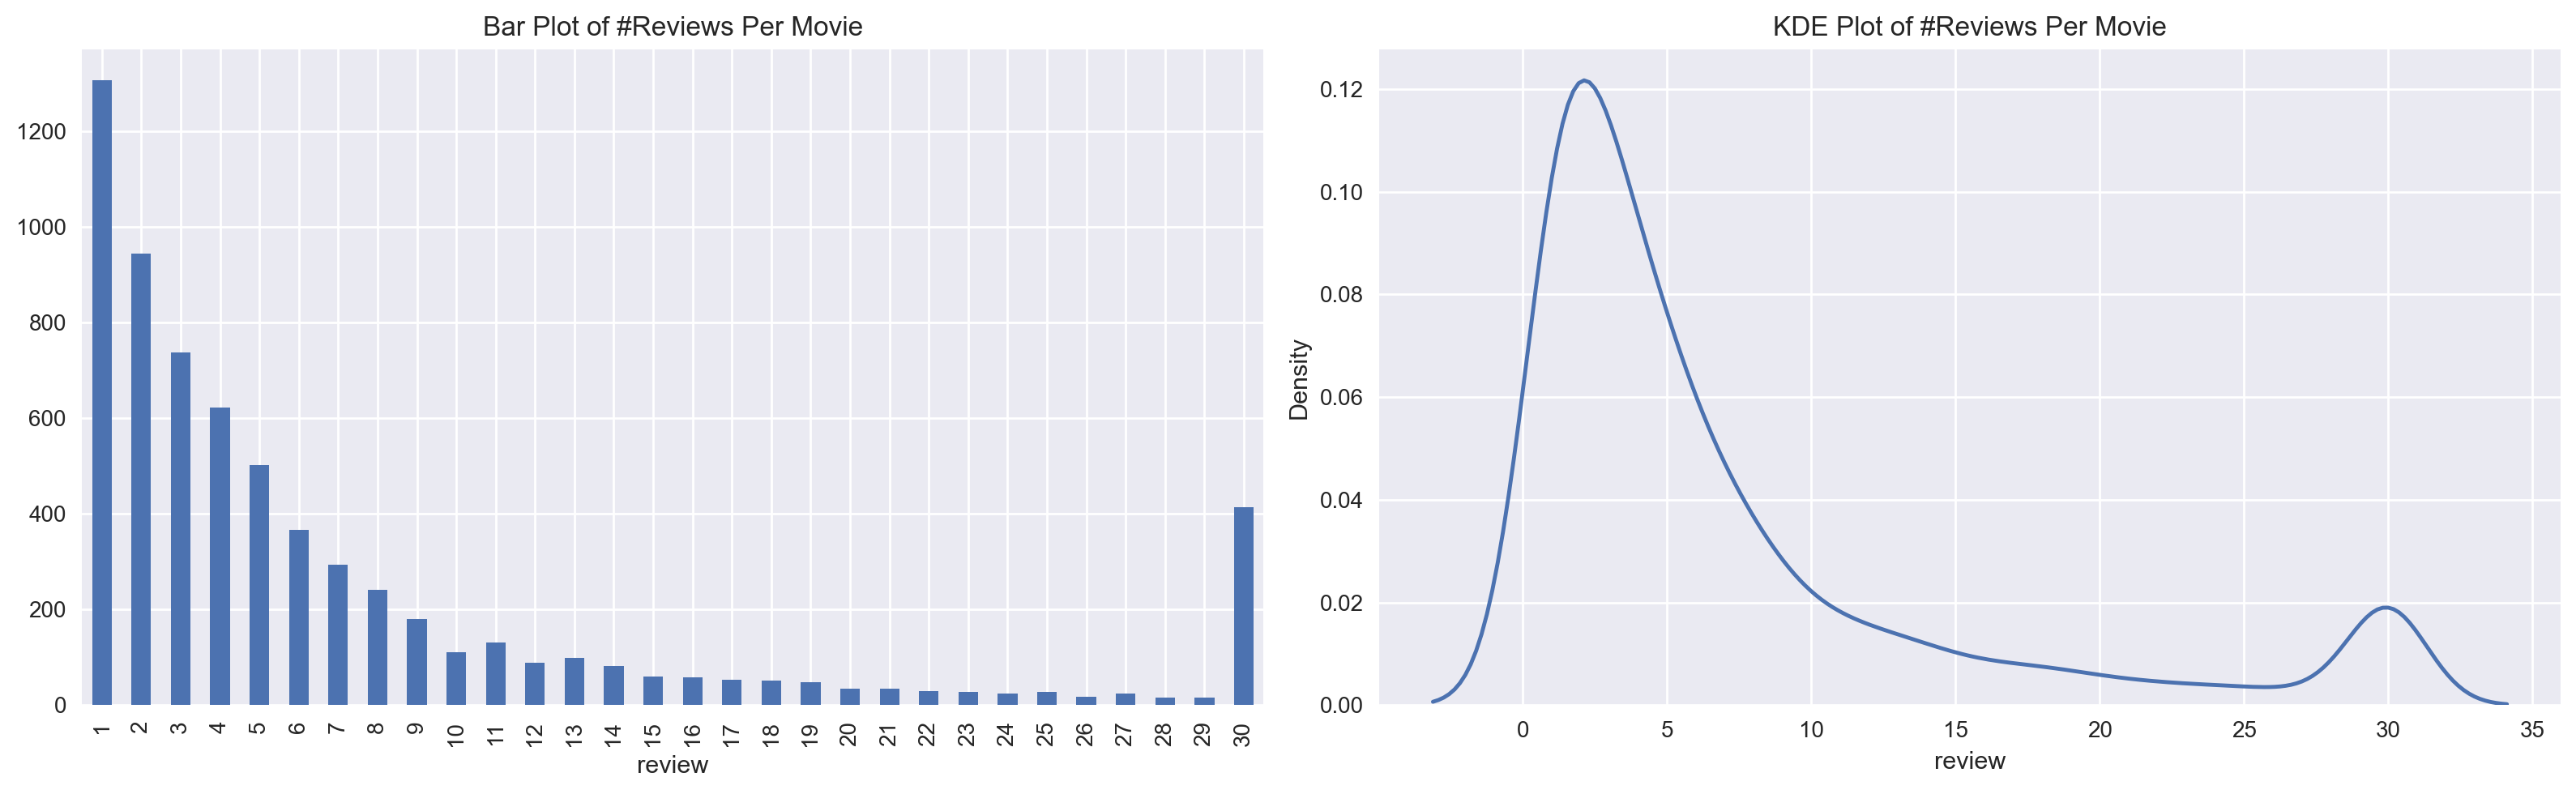

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

Most movies have fewer than 10 reviews, with most having only one review. The number of movies decreases as the number of reviews increases, except for movies with 30 reviews, which are likely popular. Let's visualize the range of movie ratings grouped by the number of reviews using boxplots.

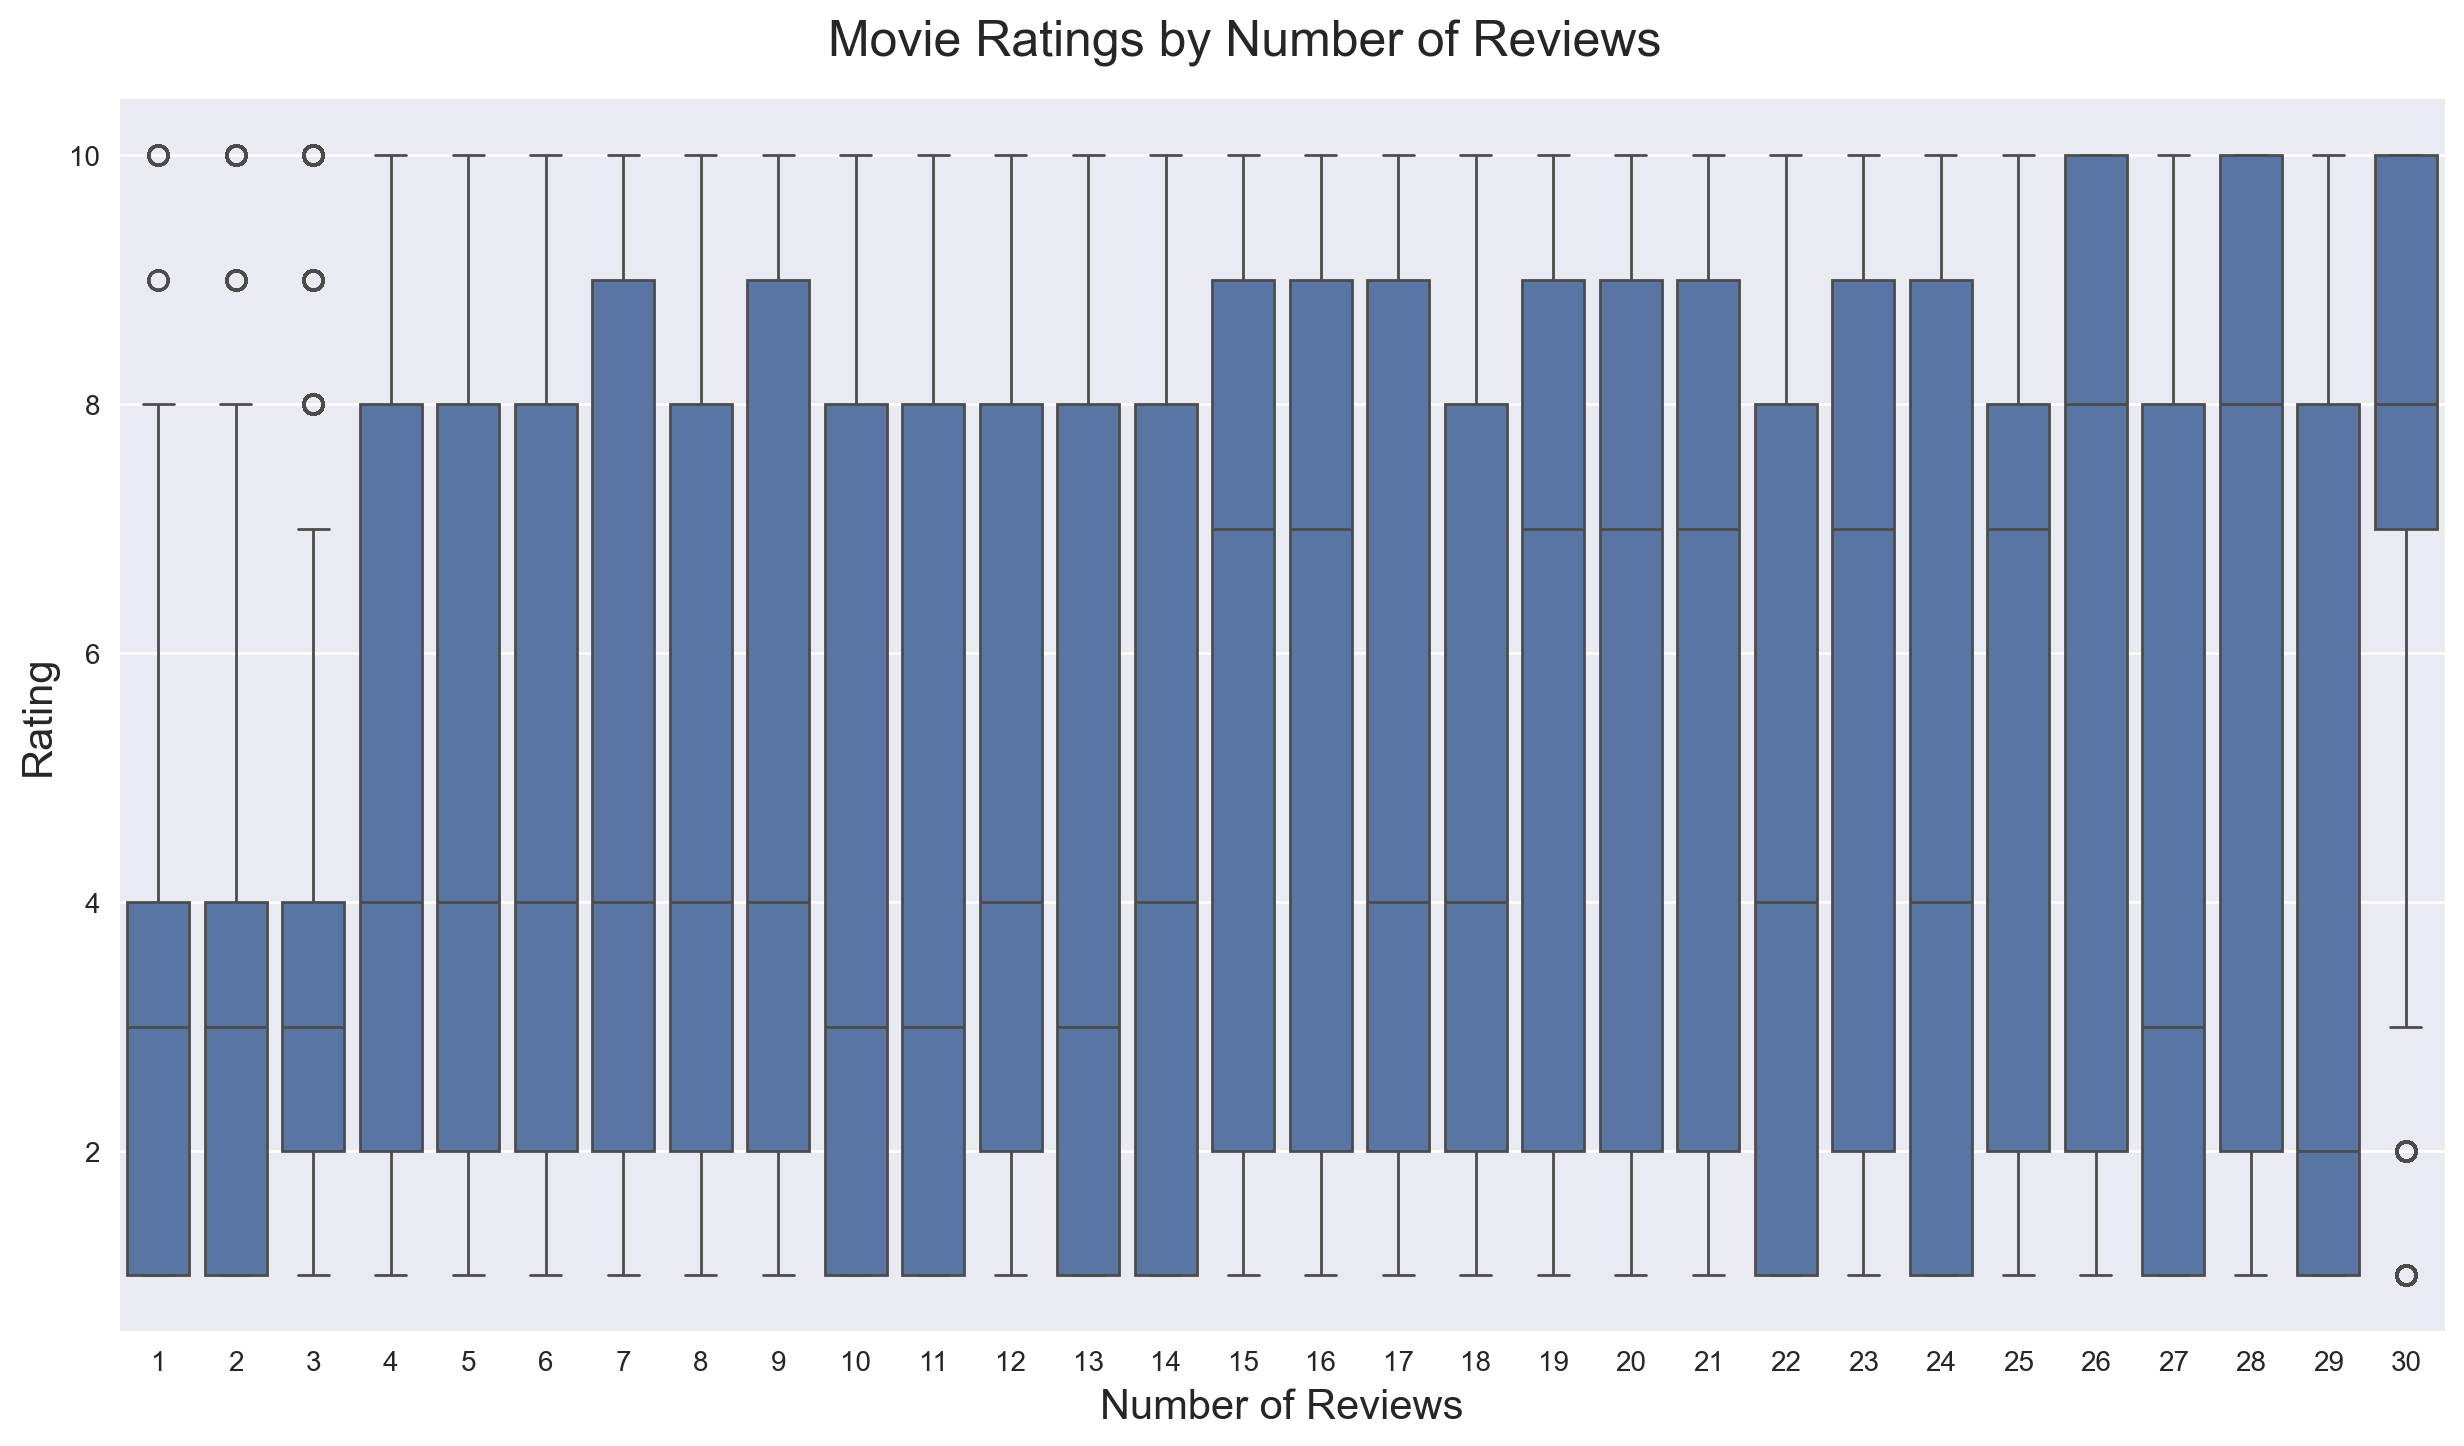

In [22]:
#Create new column with total reviews for each movie.
df_reviews['num_rev'] = df_reviews.groupby('tconst')['review'].transform('count')

#Create boxplot to display range and average of movie ratings by number of movie reviews.
fig = plt.figure(figsize=(15, 8))
sns.boxplot(x="num_rev", y="rating", data=df_reviews[['num_rev', 'rating']])
fig.suptitle('Movie Ratings by Number of Reviews', fontsize=18, y=.93)
plt.xlabel('Number of Reviews', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.show()

Movies with a high number of reviews tend to have a higher mean rating. The mean rating for movies with between 1-14 reviews is better 3 and 4, fluctuating between 15 and 25 reviews and 25 and 29 reviews, respectively. Movies with 30 reviews have a mean rating of 8. The interquartile range of ratings is lowest for movies with between 1 and 3 reviews and highest for movies with 30 reviews. This suggests that movies with 30 reviews tend to have the highest ratings, possibly indicating their popularity. 

In [23]:
#Print the number of positive and negative reviews in the dataset.
print("Total positive and negative reviews in the dataset: ")
display(df_reviews['pos'].value_counts().reset_index(drop=True))

print('\nTotal positive and negative reviews for training dataset: ')
display(df_reviews.query('ds_part == "train"')['pos'].value_counts().reset_index(drop=True))

print('\nTotal positive and negative reviews for testing dataset: ')
display(df_reviews.query('ds_part == "test"')['pos'].value_counts().reset_index(drop=True))

Total positive and negative reviews in the dataset: 


0    23715
1    23616
Name: count, dtype: int64


Total positive and negative reviews for training dataset: 


0    11912
1    11884
Name: count, dtype: int64


Total positive and negative reviews for testing dataset: 


0    11803
1    11732
Name: count, dtype: int64

Our dataset has roughly equal numbers of positive and negative reviews, which is good because we don’t need to balance the datasets. The positive and negative review distributions are similar for both the training and testing datasets. However, some review labels might be ambiguous, like a 5-star rating. Let’s visualize the rating distribution for both datasets. Note that the ‘ds_part’ column indicates which set an observation belongs to, even before we split the dataset into training and testing sets.

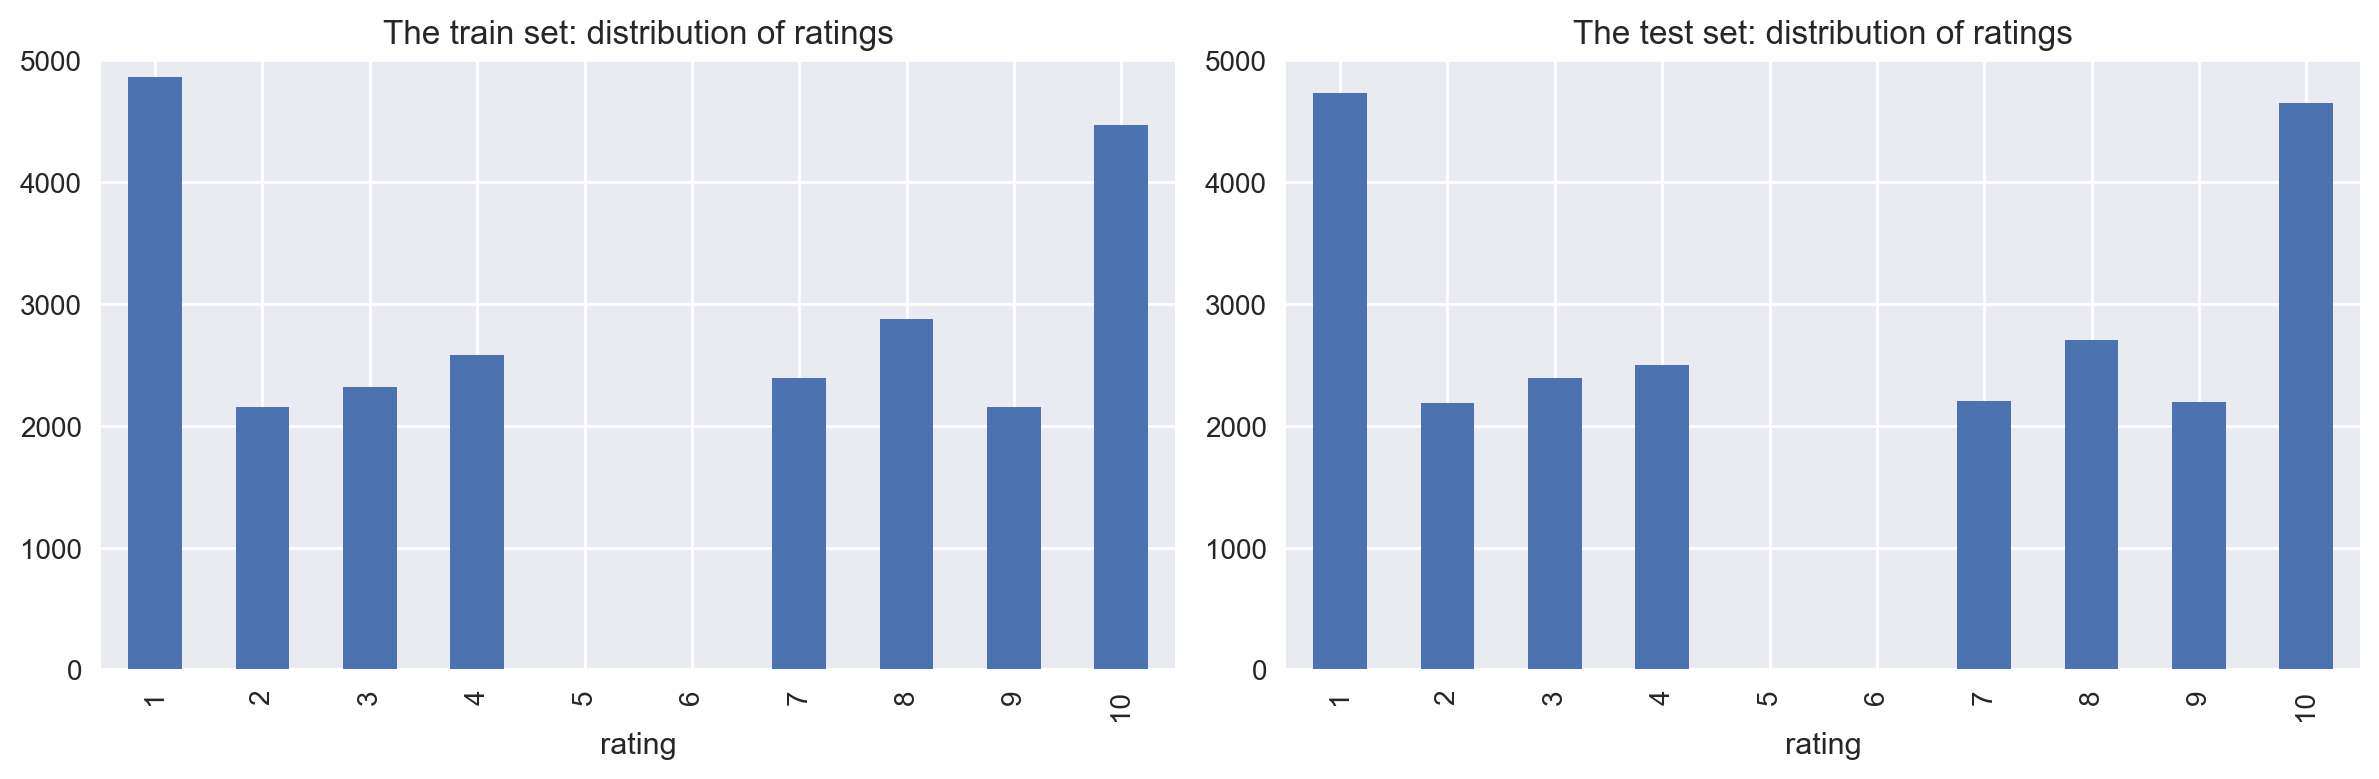

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

From these plots we can see that our concern does not apply to this dataset - that is, there are no boarderline ratings which may be taken as positive by some and negative by others. The reviews chosen appear to all have come from individuals who rated the relevant movies as between 1 and 4 or between 7 and 10; there are no reviews with ratings of 5 or 6 in this dataset. While this may be good for building our models, it might affect the real-world accuracy of our model, as ratings of 5 or 6 might be accompanied by reviews that offer both positive and negative takes on the respective movie; if this is the case, then our model might not be able to properly classify a review as positive or negative.

Distribution of negative and positive reviews over the years for two parts of the dataset

Visualize the number of positive and negative reviews per year in both the training and testing datasets. This might not be crucial for building our model, but it could be useful for predicting whether a review is positive or negative, considering the year a movie was released.

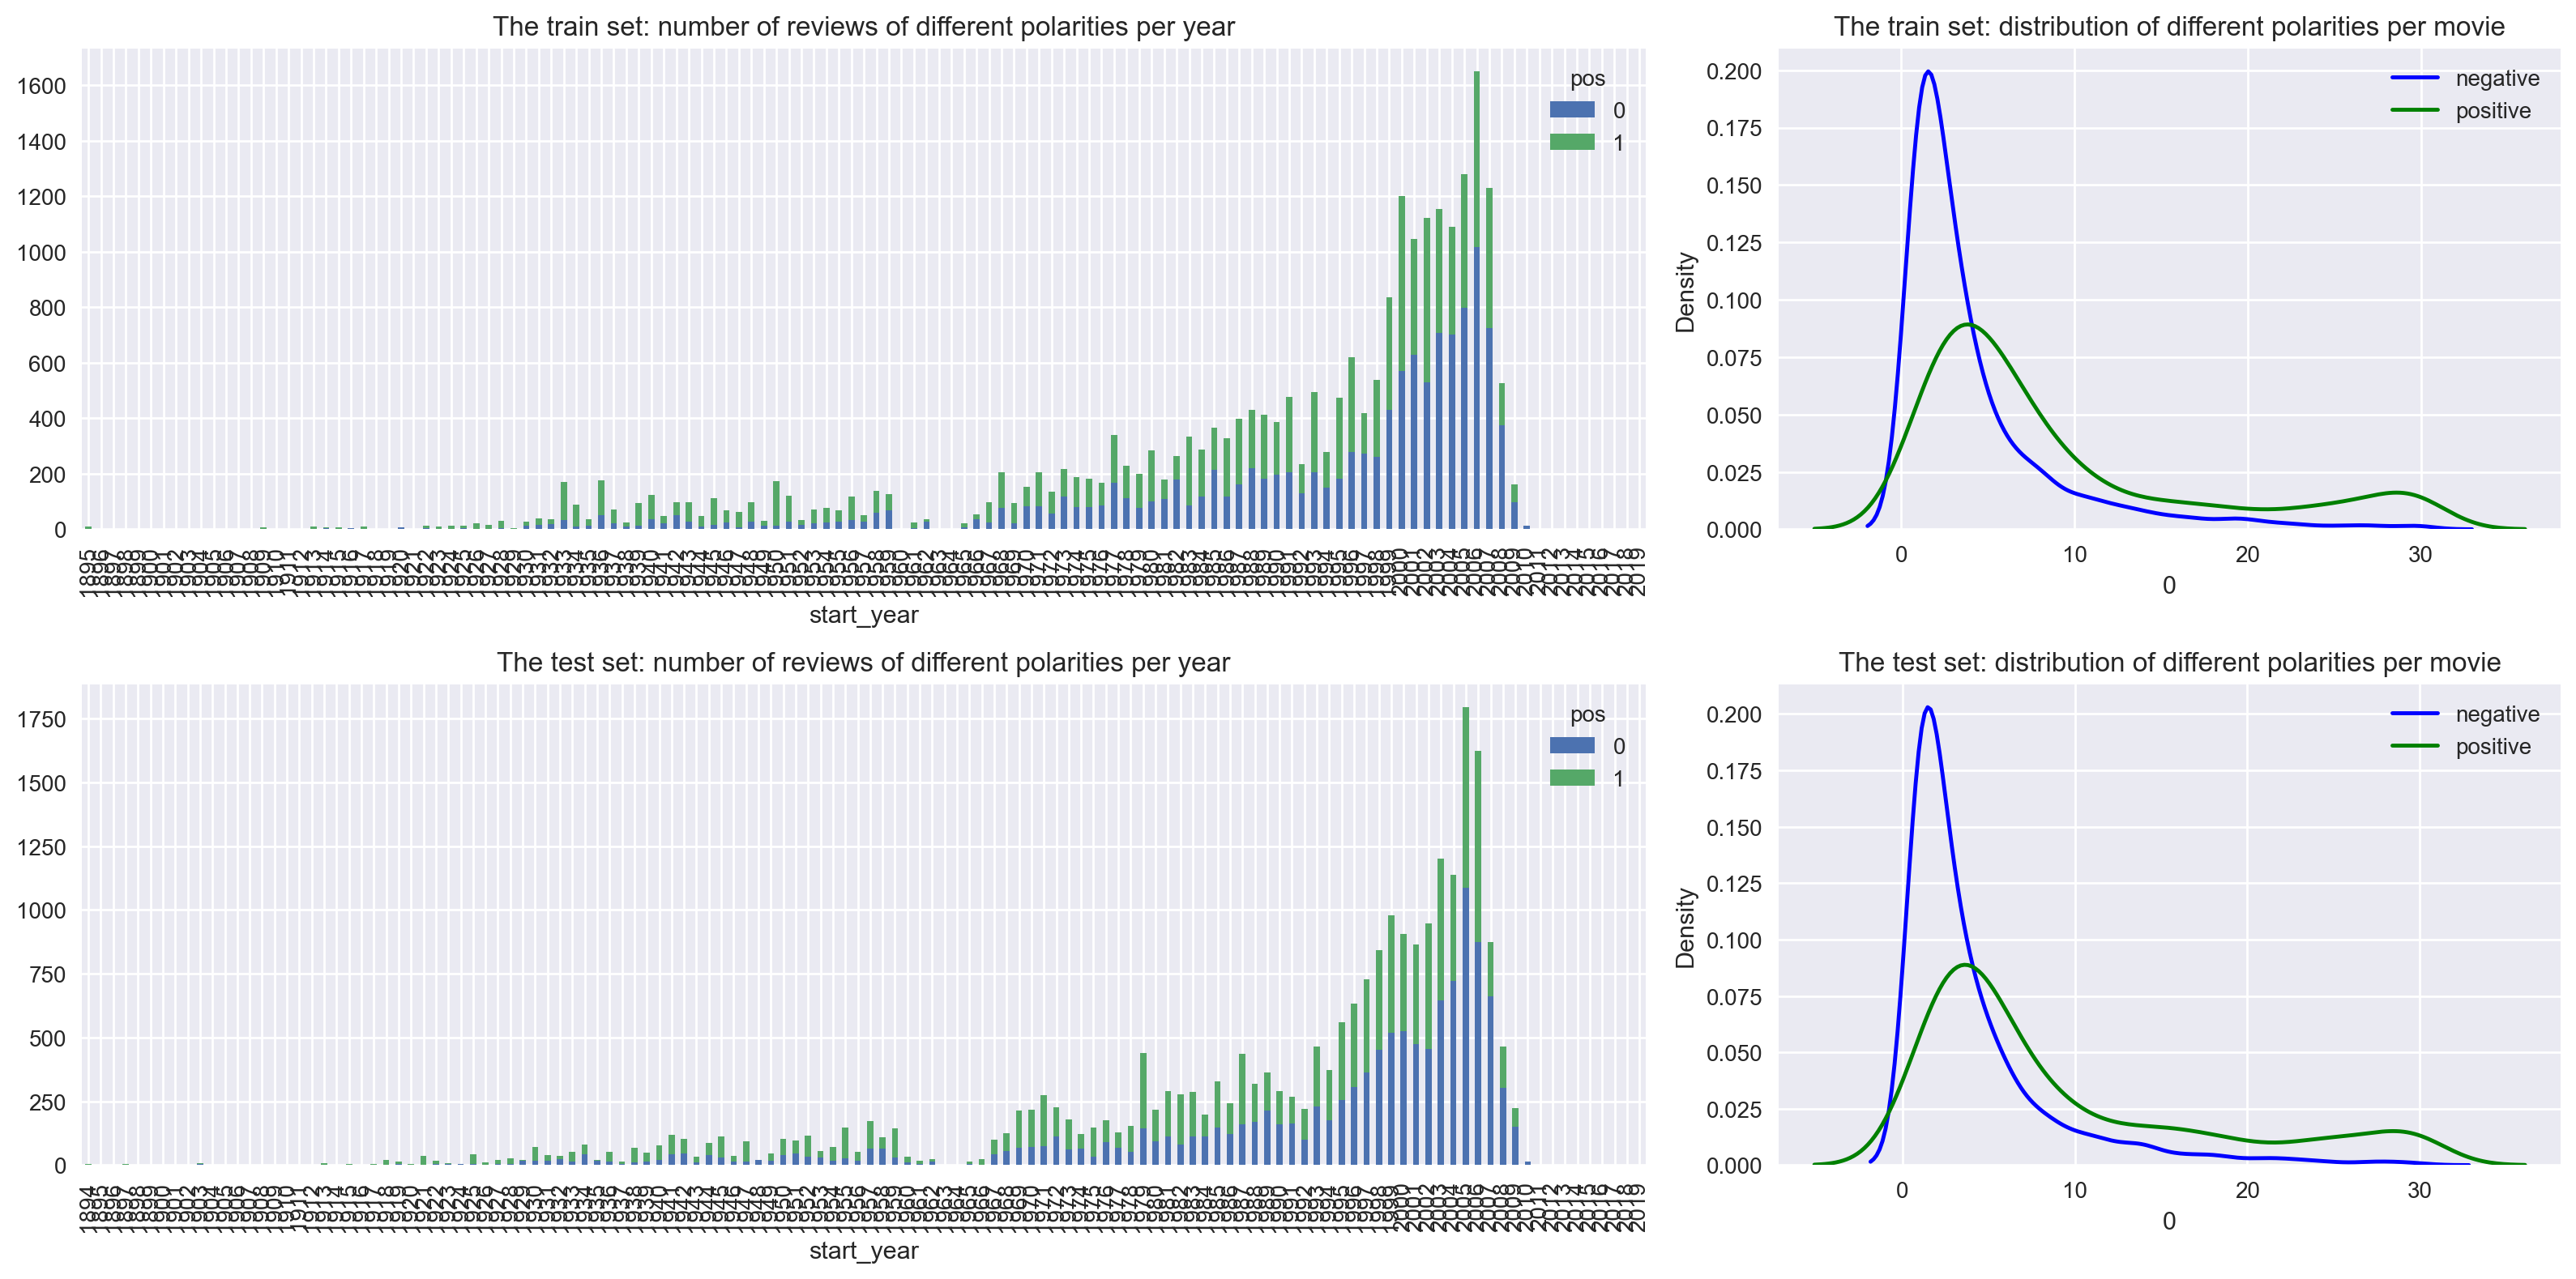

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The number of reviews increased significantly over the last two decades, as seen in subsection 2.1. Regarding review distribution, the ratio of positive to negative reviews became more balanced with later release dates, except for recent movies. The KDE plot shows a higher proportion of negative reviews for movies with fewer reviews. Positive reviews also follow a similar pattern, with a higher probability of positivity for movies with 5 or more reviews. Overall, the distribution and ratio of positive to negative reviews are similar for both training and testing datasets.

By visualizing the distribution of ratings for our train and test sets, we can verify the anticipated similarities in both the distribution of ratings and the associated polarities.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

Develop an evaluation routine for all models. This function will predict from models, obtain predicted probabilities, create ROC and PRC plots, plot F1 scores at various thresholds, and save critical stats to a dictionary for printing as a DataFrame.

In [26]:
#Create function to evaluate models.
def evaluate_model(model_name, model, train_features, train_target, test_features, test_target):
    
    #Dictionary for evaluation stats.
    eval_stats = {}
    
    #Create figure with subplots to visualize stats.
    fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 
    fig.suptitle(f'{model_name} Model Evaluation', fontsize=18)
    #For loop to calculate stats for training and testing sets.
    for type, features, target in (('Train', train_features, train_target), ('Test', test_features, test_target)):
        
        #Evaluation stats for each dataset.
        eval_stats[type] = {}
        
        #Model prediction.
        pred_target = model.predict(features)
        #Model predicted probabilities.
        pred_proba = model.predict_proba(features)[:, 1]
        
        #F1 scores for model at different thresholds.
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        #ROC_AUC score for model. Save variables for graph.
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        #PRC score for model. Save variables for graph.
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        #Create different colored lines based on whether train or test dataset.
        if type == 'Train':
            color = 'blue'
        else:
            color = 'green'

        #Plot F1 score at different thresholds.
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        #Create crosses at different thresholds.
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Threshold', fontsize=12)
        ax.set_ylabel('F1', fontsize=12)
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score', fontsize=15) 

        #Create ROC plot.
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        #Create crosses at different thresholds.
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR', fontsize=12)
        ax.set_ylabel('TPR', fontsize=12)
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve', fontsize=15)
        
        #Create PRC plot.
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        #Create crosses at different thresholds.
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall', fontsize=12)
        ax.set_ylabel('Precision', fontsize=12)
        ax.legend(loc='lower center')
        ax.set_title(f'PRC', fontsize=15)        

        #Add stats to evaluation dictionary.
        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    #Create DataFrame from evaluation stats.
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    display(df_eval_stats)
    
    return

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

We’ll split the dataset into training and testing datasets. Unlike usual, this dataset is already balanced. The ‘ds_part’ column in the DataFrame indicates whether an observation belongs to the training or testing dataset. We’ll use the ‘query’ method to split the data into the appropriate sets.

In [27]:
#Split data according to 'ds_split' value.
train = df_reviews.query('ds_part == "train"').copy()
test = df_reviews.query('ds_part == "test"').copy()

#Create target datasets.
train_y = train['pos']
test_y= test['pos']

#Create feature datasets.
train_X = train.rev_norm
test_X = test.rev_norm

print(f'Shape of training dataset: {train.shape}')
print(f'Shape of testing dataset: {test.shape}')

Shape of training dataset: (23796, 19)
Shape of testing dataset: (23535, 19)


We split the data into training and testing datasets based on each observation's 'ds_part' value. The target datasets contain only the 'pos' value, indicating whether a review is positive or negative. The feature datasets contain normalized reviews, with only letters and apostrophes retained.

## Working with models

We'll build and evaluate 4 classification models to predict whether a review is postiive or negative with an F1 score greater than .85. We'll use the 'evaluate_model' function from section 3 to evaluate the models.

### Model 1 - Dummy Model

,Train,Test
Accuracy,0.5,0.5
F1,0.5,0.5
APS,0.5,0.5
ROC AUC,0.5,0.5


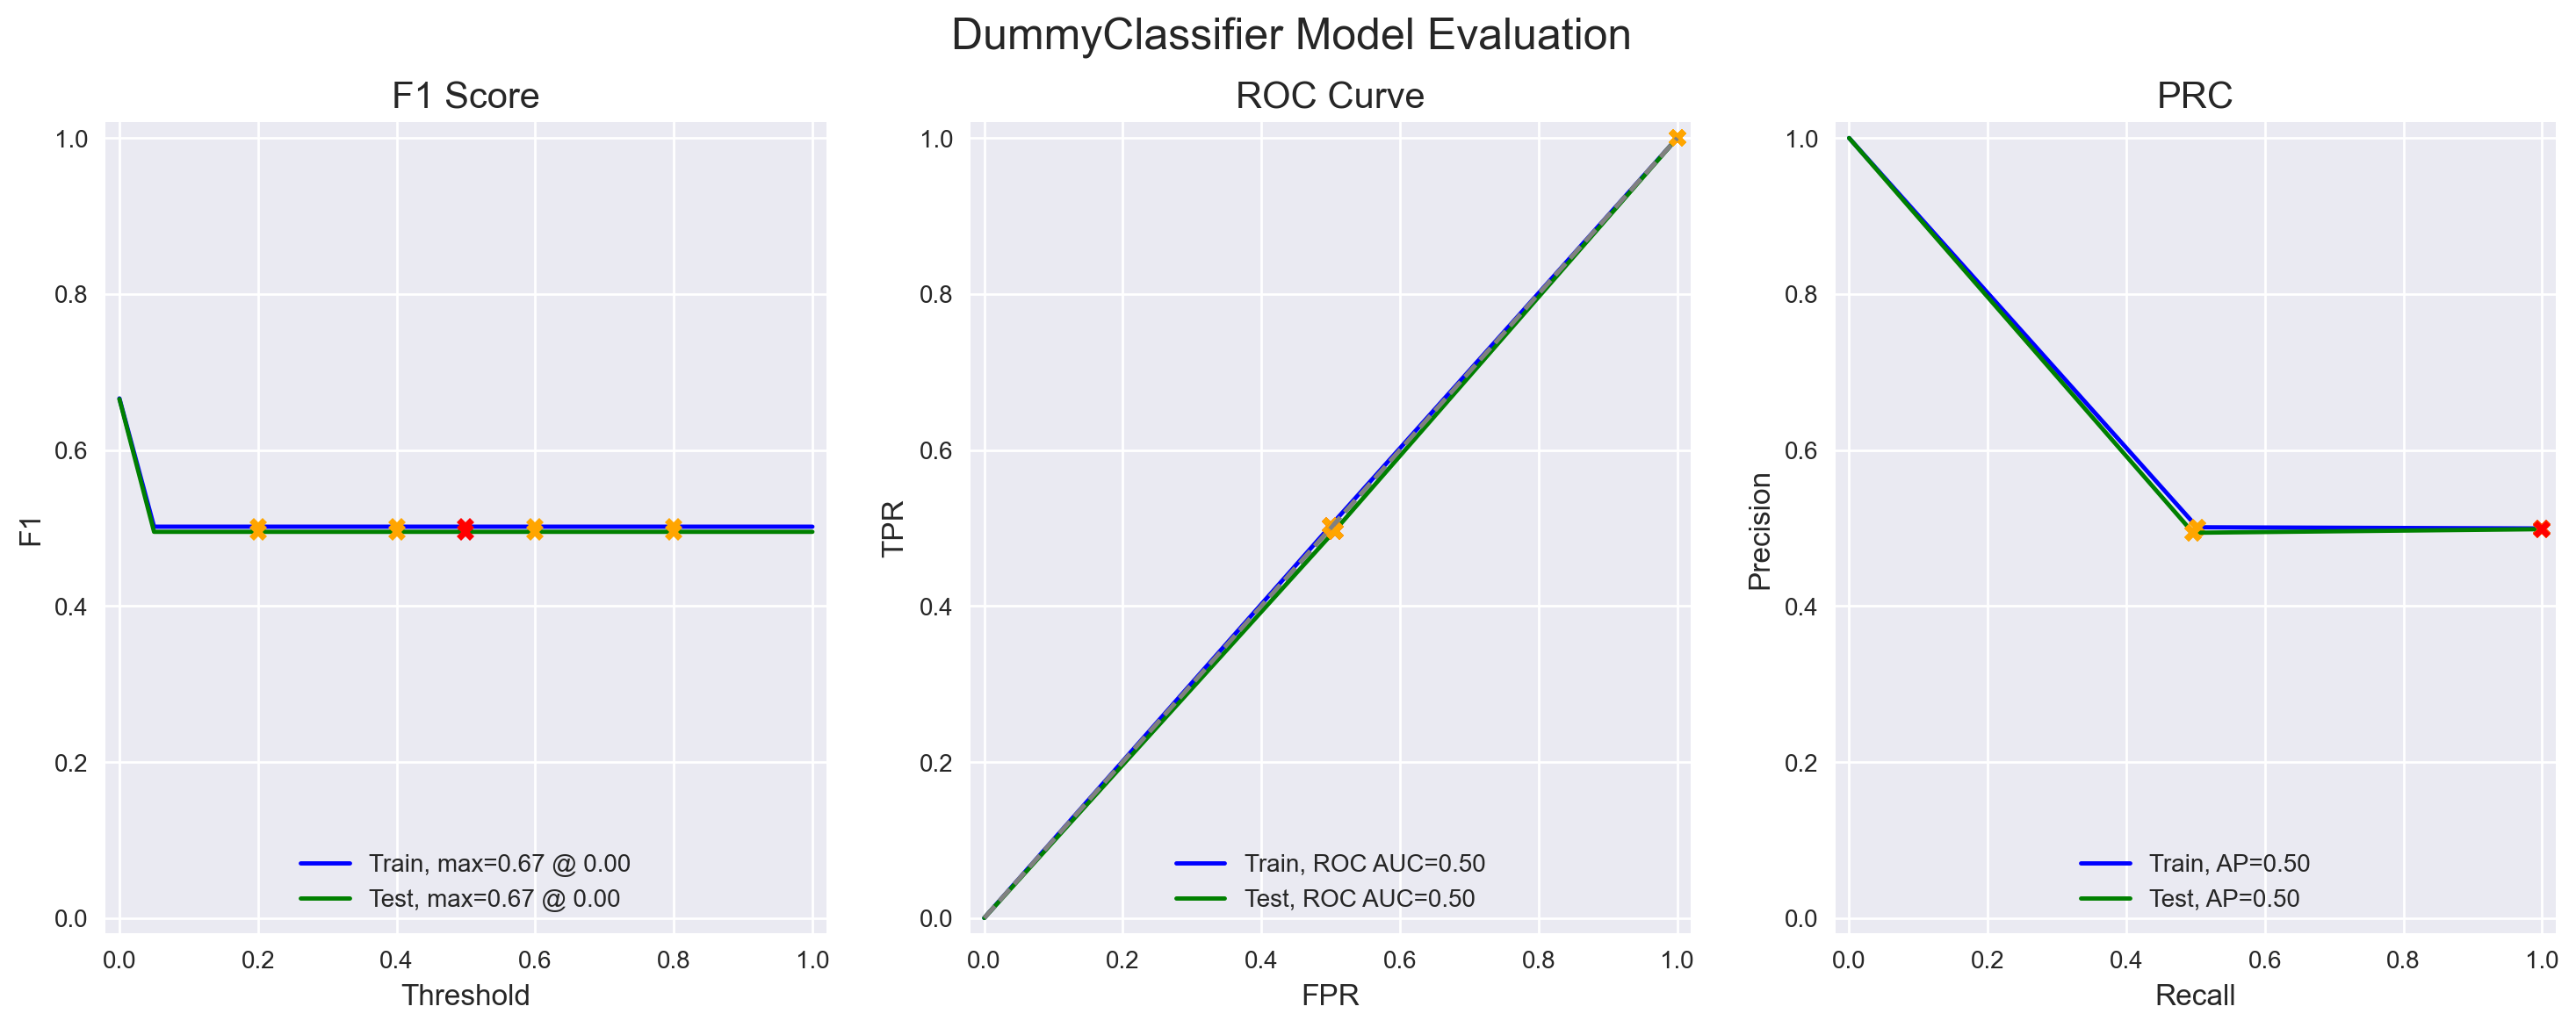

In [28]:
dummy_model = DummyClassifier(strategy='stratified', random_state=12345)
dummy_model.fit(train_X, train_y)

evaluate_model('DummyClassifier', dummy_model, train_X, train_y, test_X, test_y)

Our dummy model predicted the corrected answers with an accuracy of .5 in both training and testing sets. F1, APS, and AUC-ROC scores were also .5, indicating no better classification than chance. This model serves as a benchmark for evaluating out later models' performance.

### Model 2 - NLTK, TF-IDF and LR

In [29]:
#Create lemmatization function.
def lemmatize(corpus):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(corpus)
    lemmatized = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized

In [30]:
#Lemmatize words
train_X_lem_nltk = train_X.progress_apply(lemmatize)
test_X_lem_nltk = test_X.progress_apply(lemmatize)

  0%|          | 1/23796 [00:00<02:00, 196.73it/s]


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\IU STUDENT/nltk_data'
    - 'c:\\Users\\IU STUDENT\\anaconda3\\envs\\ML_texts\\nltk_data'
    - 'c:\\Users\\IU STUDENT\\anaconda3\\envs\\ML_texts\\share\\nltk_data'
    - 'c:\\Users\\IU STUDENT\\anaconda3\\envs\\ML_texts\\lib\\nltk_data'
    - 'C:\\Users\\IU STUDENT\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


,Train,Test
Accuracy,0.94,0.88
F1,0.94,0.88
APS,0.98,0.95
ROC AUC,0.98,0.95


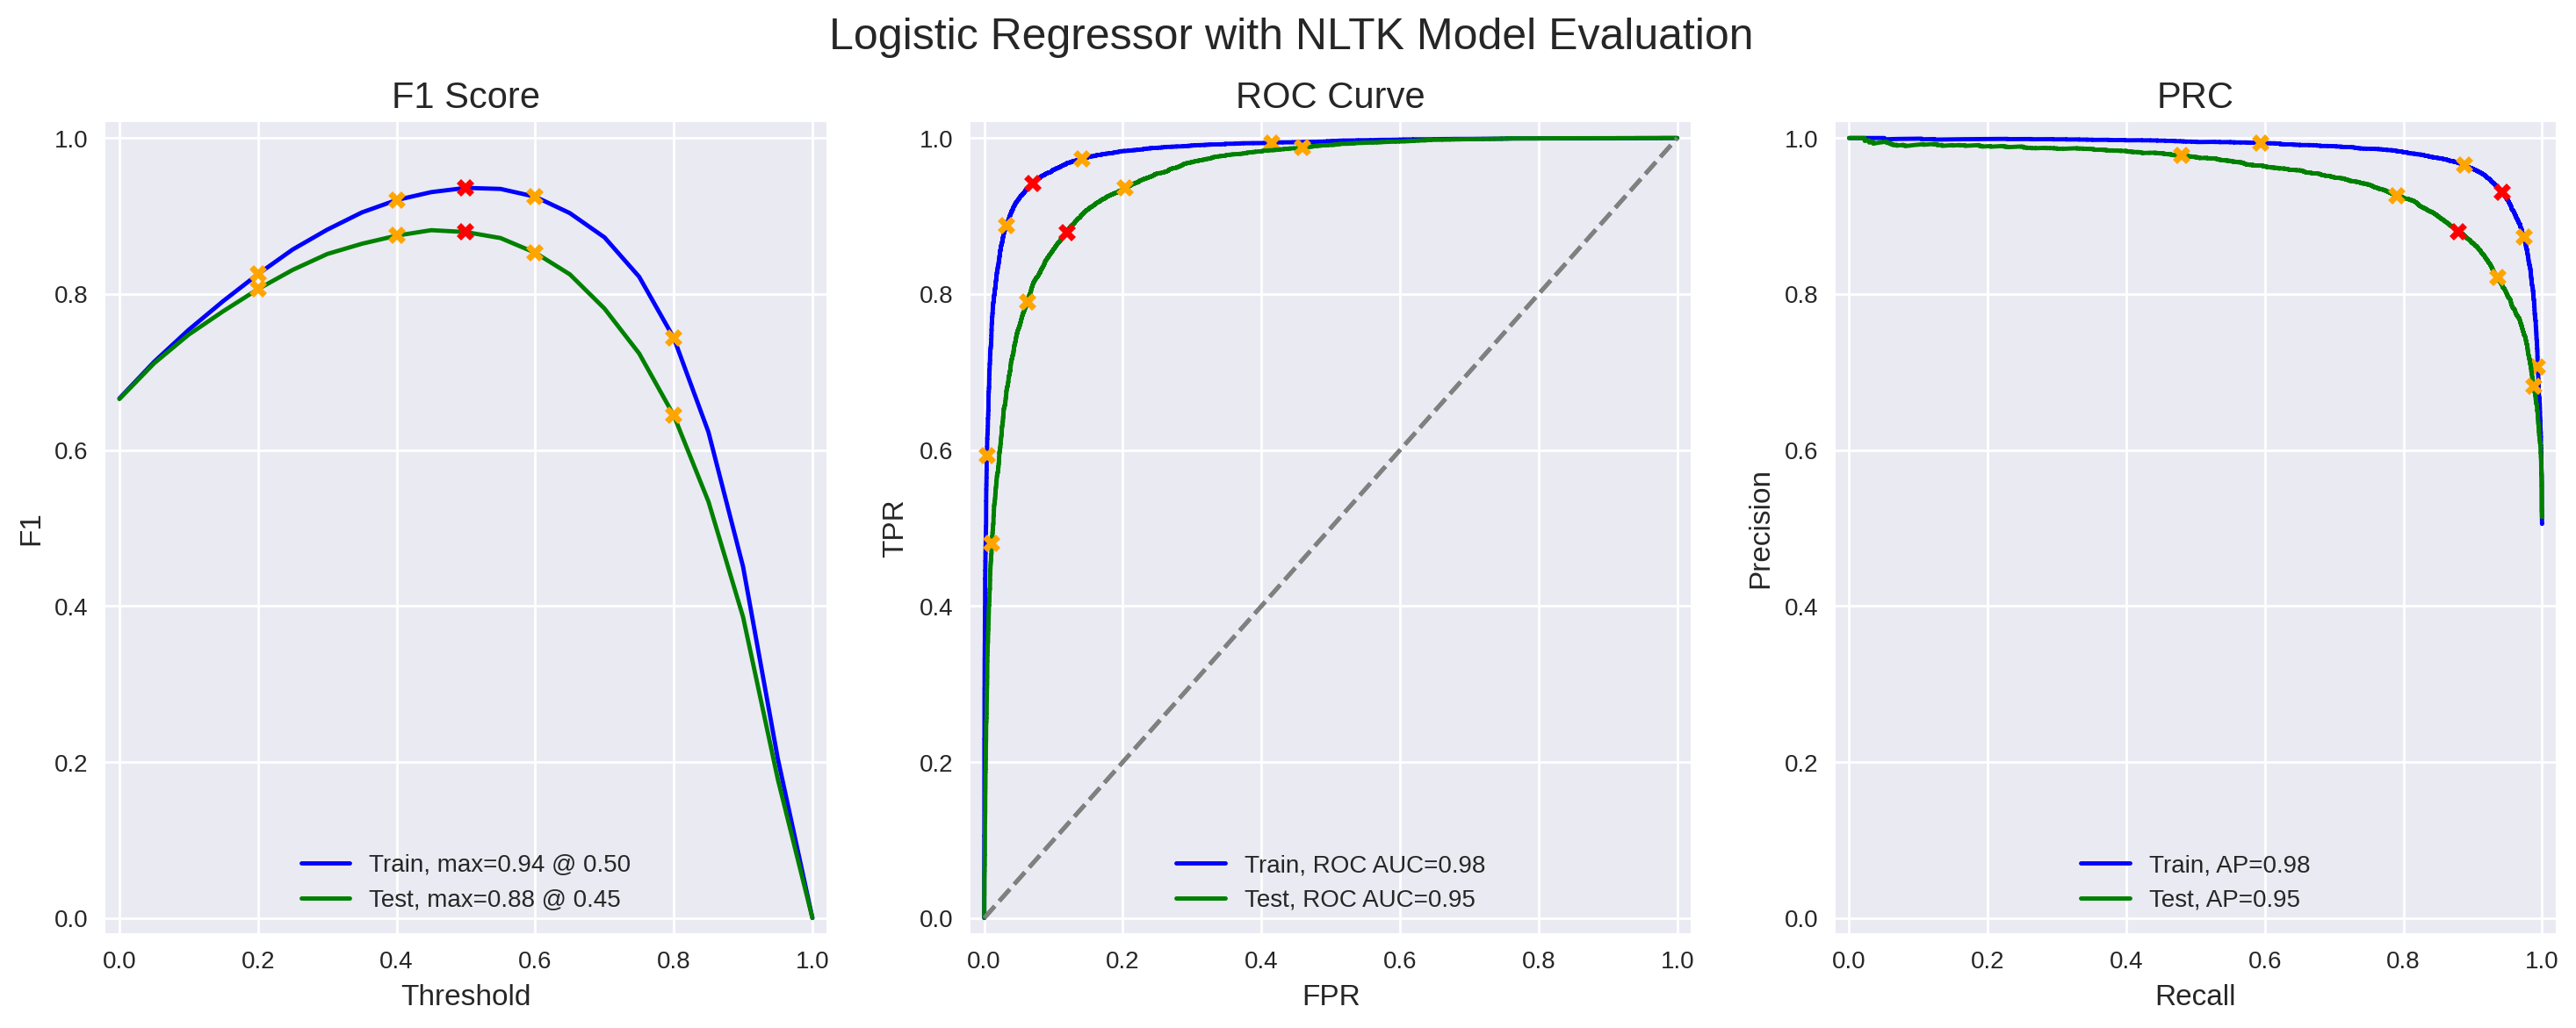

In [ ]:
#Create list of stopwords.
stop_words = set(stopwords.words('english'))

#Create a TF-IDF vectorizer.
model2_tf_idf = TfidfVectorizer(stop_words=stop_words)

#Fit vectorizer to training dataset. Transform training and testing da
model2_train_X = model2_tf_idf.fit_transform(train_X_lem_nltk)
model2_test_X = model2_tf_idf.transform(test_X_lem_nltk)

#Create logistic regression model and fit it.
model2 = LogisticRegression(random_state=12345, solver='saga')
model2.fit(model2_train_X, train_y) ;

#Evaluate model.
evaluate_model('Logistic Regressor with NLTK', model2, model2_train_X, train_y, model2_test_X, test_y)

#Delete unnecessary variables.
del train_X_lem_nltk
del test_X_lem_nltk

Our logistic regression model outperformed the dummy model as evident from the plots. We lemmatized words in reviews from both datasets, vectorized them, and trained the model. The model achieved near-perfect average precision and AUC ROC scores. The training set had a higher F1 score than the testing set, but the test set scored .88, exceeding the company's minimum requirement of .85.

### Model 3 - spaCy, TF-IDF and LR

In [ ]:
#Create a spacy object.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#Obtain set of stopwords from spacy.
stop_words = nlp.Defaults.stop_words

#Create function to lemmatize words.
def spacy_lemmatize(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

In [ ]:
#Lemmatize reviews in training and testing datasets.
train_X_lem_spacy = train_X.progress_apply(spacy_lemmatize)
test_X_lem_spacy = test_X.progress_apply(spacy_lemmatize)

100%|██████████| 23535/23535 [03:36<00:00, 108.52it/s]


,Train,Test
Accuracy,0.93,0.87
F1,0.93,0.87
APS,0.98,0.94
ROC AUC,0.98,0.95


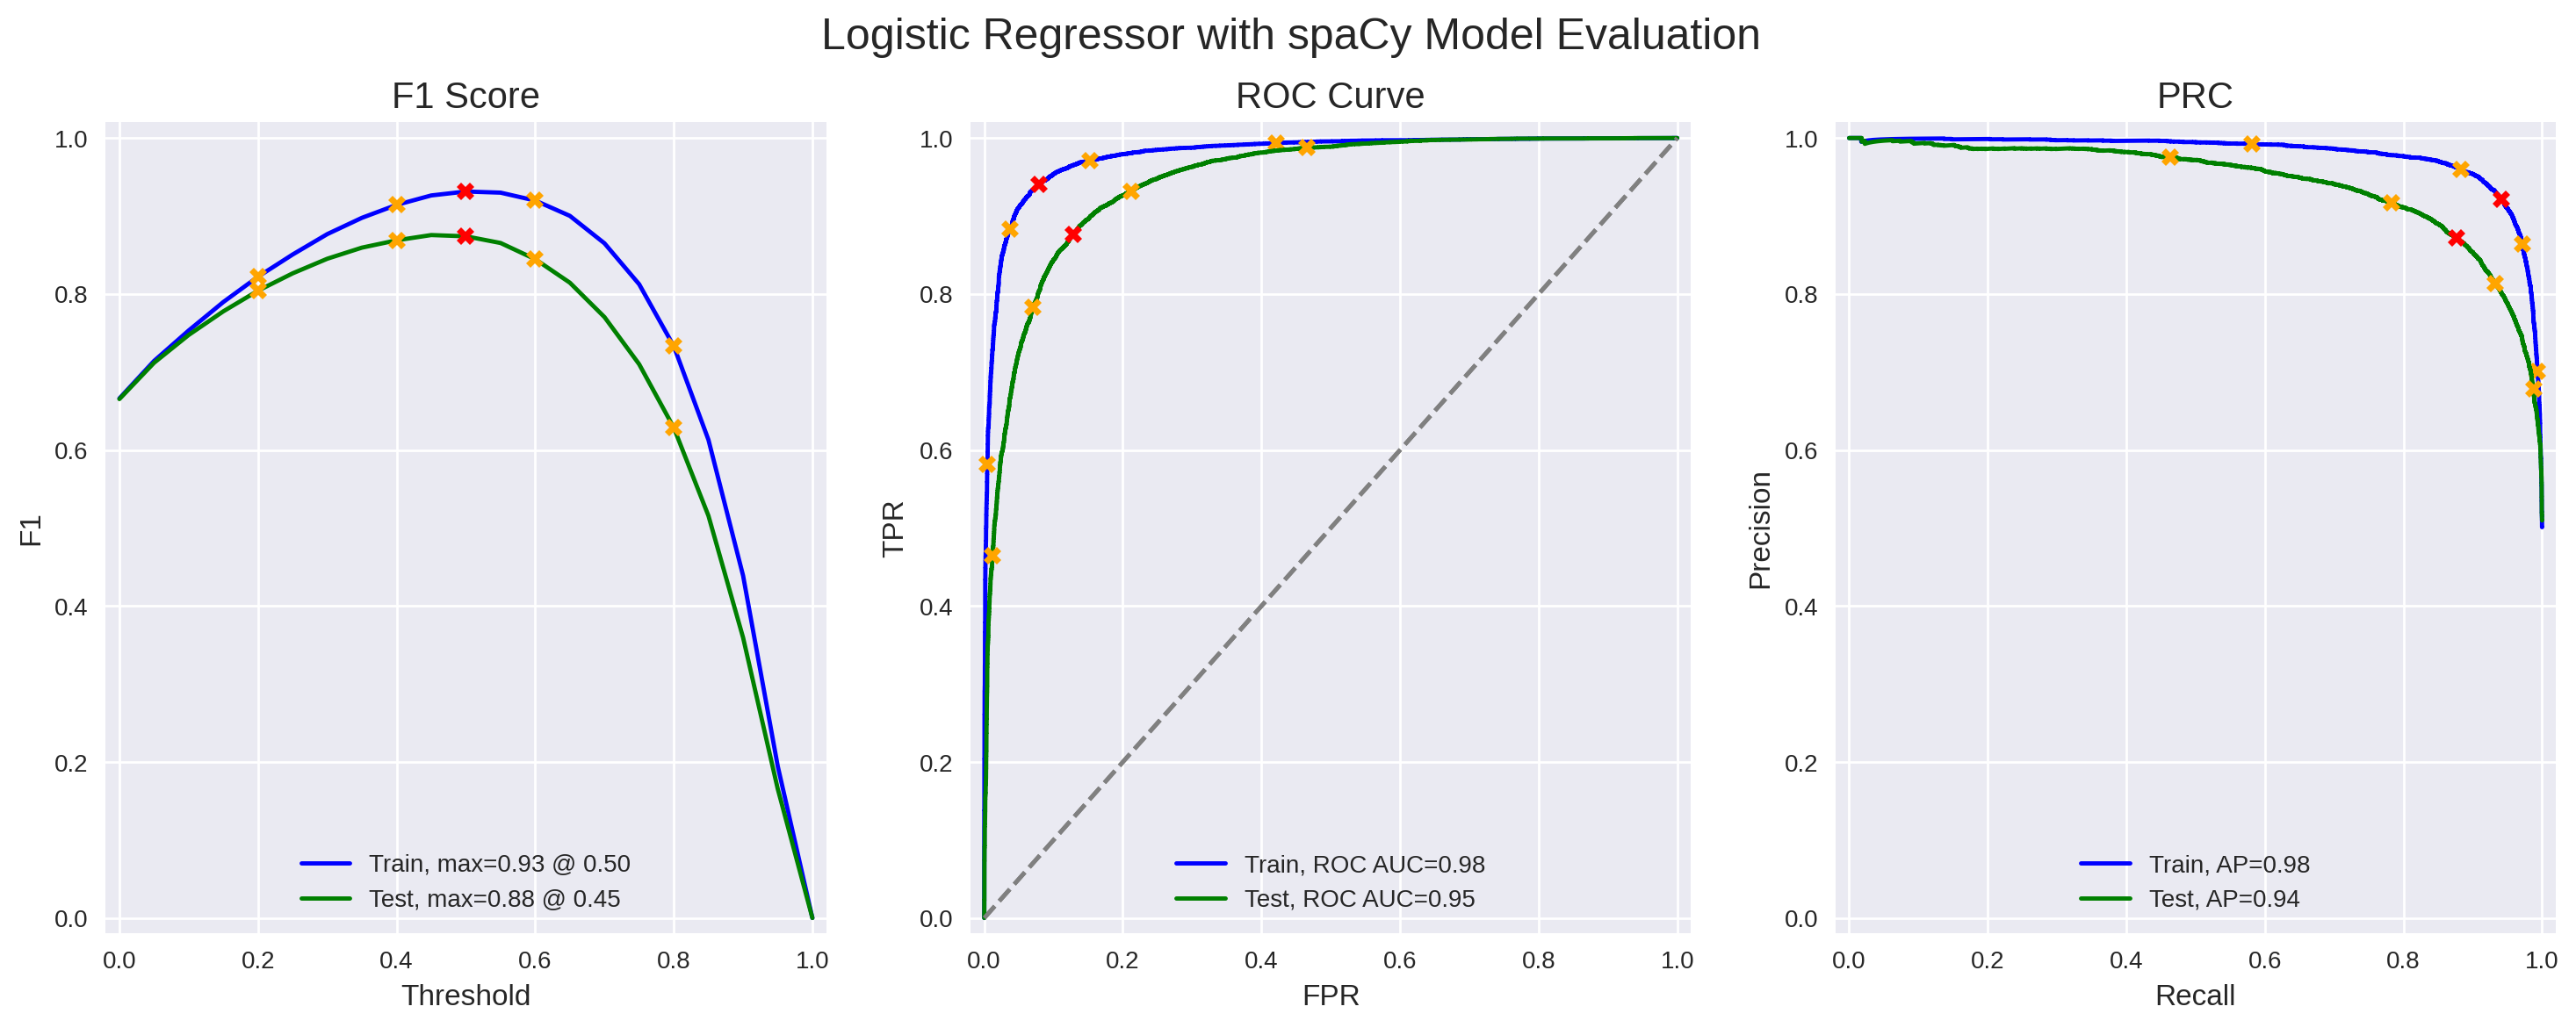

In [ ]:
#Create new instance of vectorizer.
model3_tf_idf = TfidfVectorizer(stop_words=stop_words)

#Fit vectorizer to training dataset. Transform training and testing da
model3_train_X = model3_tf_idf.fit_transform(train_X_lem_spacy)
model3_test_X = model3_tf_idf.transform(test_X_lem_spacy)

#Create logistic regression model and fit it.
model3 = LogisticRegression(random_state=12345, solver='saga')
model3.fit(model3_train_X, train_y) ;

#Evaluate model.
evaluate_model('Logistic Regressor with spaCy', model3, model3_train_X, train_y, model3_test_X, test_y)

Our logistic regression model, tokenized using spaCy, slightly lower accuracy and F1 scores than the same model with NLTK. However, the difference is minimal, about 0.01 points for each metric. Given the F1 score on the testing datasets, it meets the minimum-score criteria set by the Film Junky Union.

### Model 4 - spaCy, TF-IDF and LGBMClassifier

,Train,Test
Accuracy,0.91,0.85
F1,0.91,0.86
APS,0.97,0.93
ROC AUC,0.97,0.93


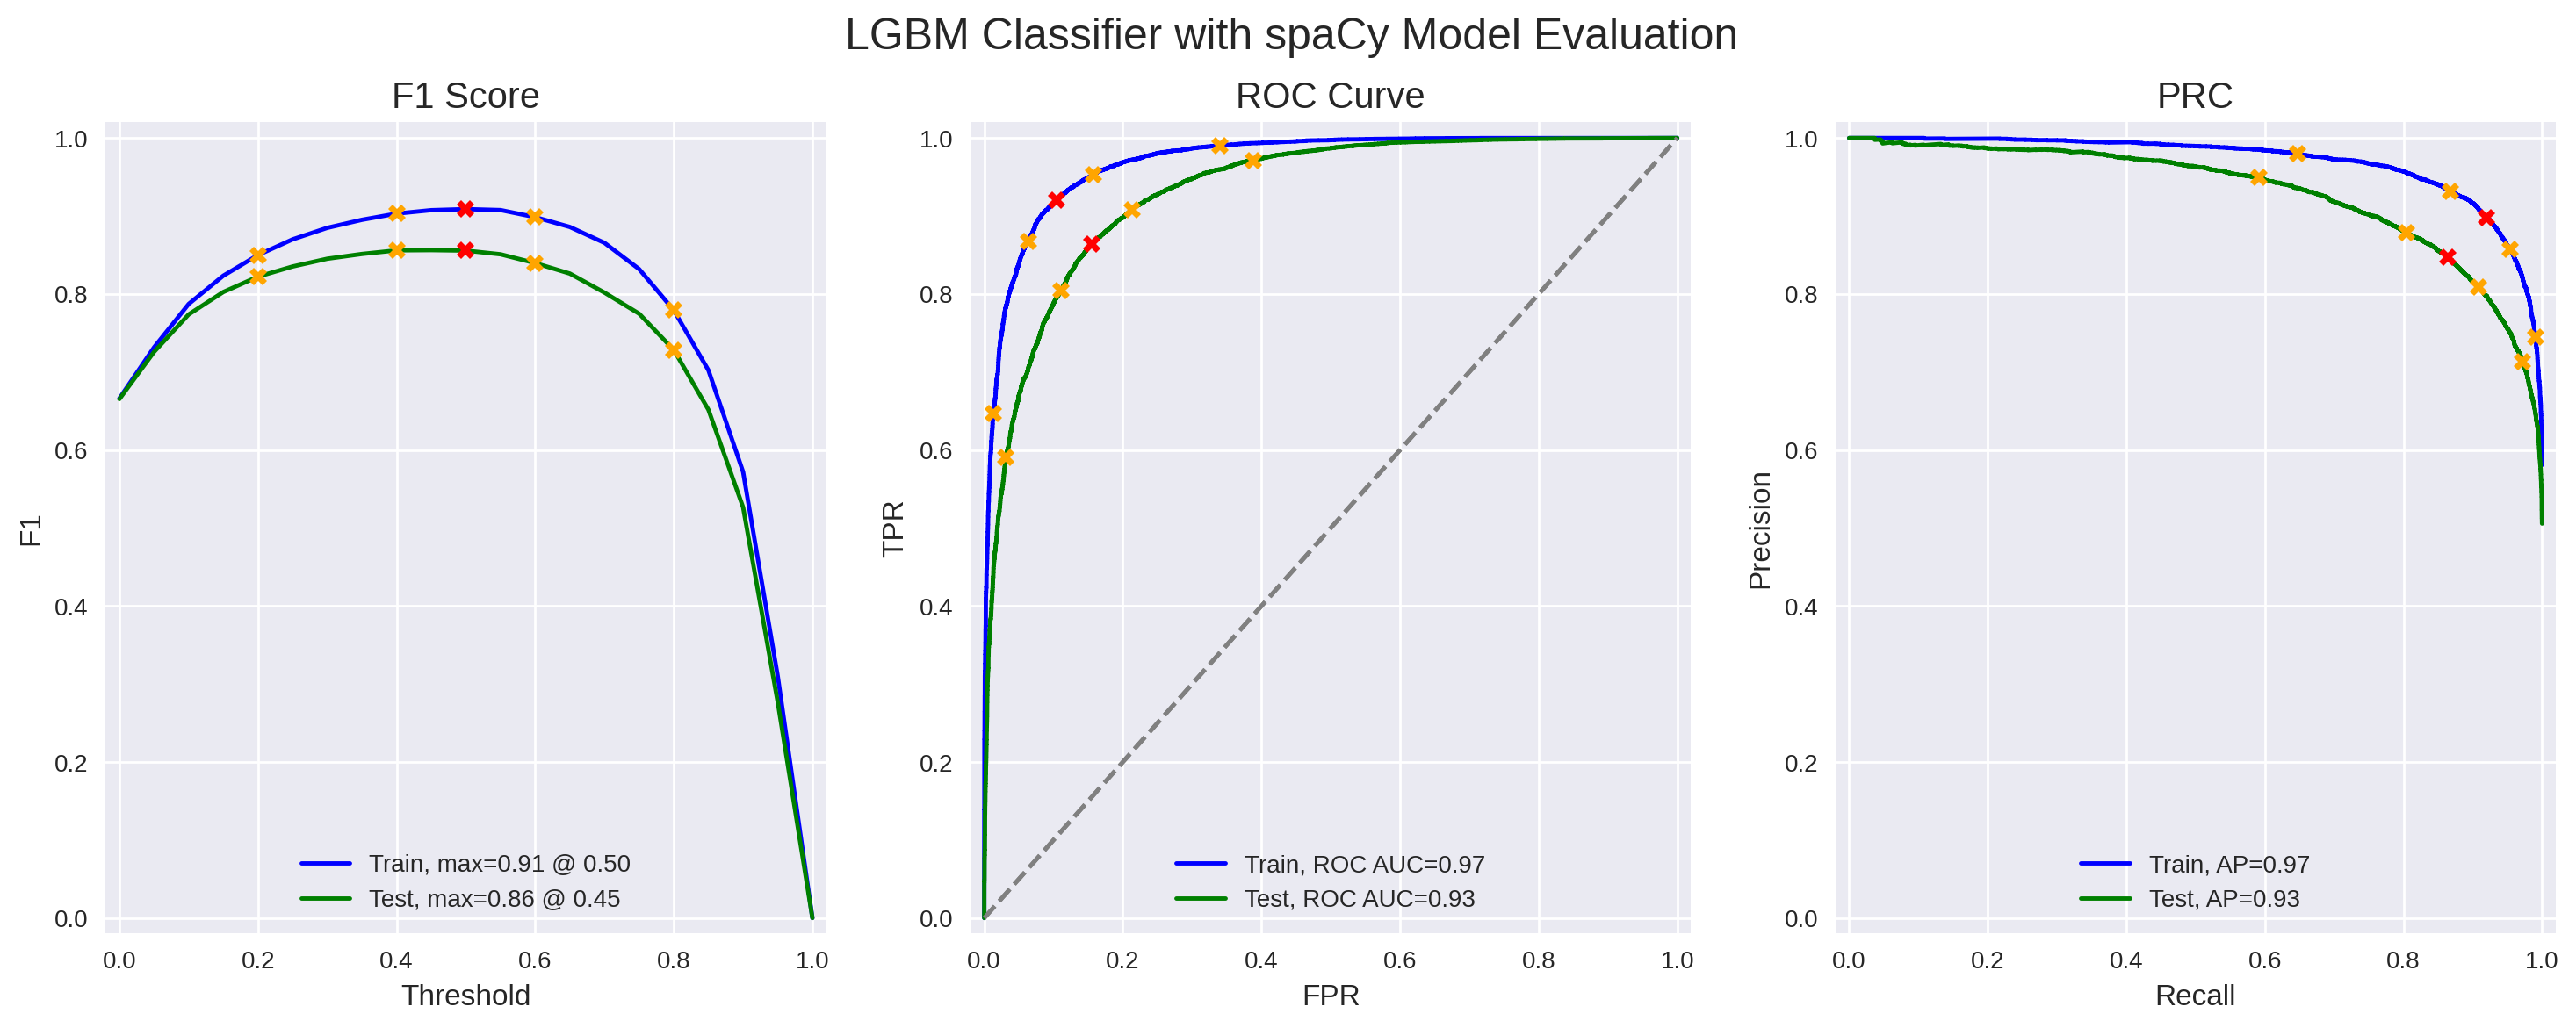

In [ ]:
#Create LGBMClassifier model.
model4 = LGBMClassifier(random_state=12345)

#Fit model to previously tokenized/lemmatize and vectorized datasets.
model4.fit(model3_train_X, train_y)

#Evaluate model.
evaluate_model('LGBM Classifier with spaCy', model4, model3_train_X, train_y, model3_test_X, test_y)

Our LGBMClassifier performs worse than our previous model on the same datasets. However, it meets the Film Junky Union's minimum threshold score for a review classification model with an F1 score of .85 on the testing dataset.

In [ ]:
#Delete unnecessary variables.
del train_X_lem_spacy
del test_X_lem_spacy

Tran and Test Model Conclusion:

We trained several NLP models to convert text into vectors. Methods included tokenization with NLTK, spaCy, and vectorization with TF-IDF. Model 2, combining NLTK, TF-IDF, and logistic regression, achieved the highest F1 score (.88) for the training datasets. Other models, except the dummy model, had similar scores.

## My Reviews

In [ ]:
#Create DataFrame with personally-generated reviews.
my_reviews = pd.DataFrame([
    'I hated this movie. I expected more and was really dissapointed',
    'This movie made me fall asleep in the theater. It was pretty boring.',
    'It is not every day that you come across such a captivating and amazing movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'Trillogies aren\'t often good, which is why I was so surprised how great this movie was!',
    'This is a movie I could take or leave. It was not the most amazing, but it was still enjoyable. I would watch it again.',
    'This movie just rehashed the same old, tired jokes as every other b-movie film. It lacked originality and was of poor quality overall.',
    'I am usually hesitant with starting new series, but I fell in love with this one instantly. After the first episode I could not stop! I loved every season and hope they make more'
], columns=['review'])

#Add column to reviews to indicate whether reviews are positive or negative.
my_reviews['pos'] = [0, 0, 1, 0, 1, 1, 0, 1]

#Normalize reviews.
my_reviews['review_norm'] = my_reviews['review'].apply(reduce_char)

#Display DataFrame.
display(my_reviews.head())

,review,pos,review_norm
0,I hated this movie. I expected more and was re...,0,i hated this movie i expected more and was rea...
1,This movie made me fall asleep in the theater....,0,this movie made me fall asleep in the theater ...
2,It is not every day that you come across such ...,1,it is not every day that you come across such ...
3,Even the actors looked really old and disinter...,0,even the actors looked really old and disinter...
4,"Trillogies aren't often good, which is why I w...",1,trillogies aren't often good which is why i wa...


Each review has been processed to contain only letter and apostrophes. We also added sentiment for each review to compare actual sentiment with model predictions.

### Model 2 - NLTK, TF-IDF, LR

In [ ]:
#Lemmatize reviews.
texts = my_reviews['review_norm'].apply(lemmatize)

#Vectorize reviews and obtain model predictions.
pred_prob = model2.predict_proba(model2_tf_idf.transform(texts))[:, 1]

#Print actual vs predicted sentiment values with review sample.
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if pred_prob[i] < .5 else 1} | Text: {review[:50]}')

Actual: 0 | Predicted: 0 | Text: i hated this movie i expected more and wa really d
Actual: 0 | Predicted: 0 | Text: this movie made me fall asleep in the theater it w
Actual: 1 | Predicted: 1 | Text: it is not every day that you come across such a ca
Actual: 0 | Predicted: 0 | Text: even the actor looked really old and disinterested
Actual: 1 | Predicted: 1 | Text: trillogies are n't often good which is why i wa so
Actual: 1 | Predicted: 1 | Text: this is a movie i could take or leave it wa not th
Actual: 0 | Predicted: 0 | Text: this movie just rehashed the same old tired joke a
Actual: 1 | Predicted: 1 | Text: i am usually hesitant with starting new series but


Model 2, which achieved the highest F1 score on the testing datasets in the previous section, accurately predicted the sentiment of each review.

### Model 3 - spaCy, TF-IDF, LR

In [ ]:
#Lemmatize reviews.
texts = my_reviews['review_norm'].apply(spacy_lemmatize)

#Vectorize reviews and obtain model predictions.
pred_prob = model3.predict_proba(model3_tf_idf.transform(texts))[:, 1]

#Print actual vs predicted sentiment values with review sample.
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if pred_prob[i] < .5 else 1} | Text: {review[:50]}')

Actual: 0 | Predicted: 0 | Text: hate movie expect dissapointe
Actual: 0 | Predicted: 0 | Text: movie fall asleep theater pretty boring
Actual: 1 | Predicted: 1 | Text: day come captivating amazing movie
Actual: 0 | Predicted: 0 | Text: actor look old disintereste get pay movie soulless
Actual: 1 | Predicted: 1 | Text: trillogie good surprised great movie
Actual: 1 | Predicted: 1 | Text: movie leave amazing enjoyable watch
Actual: 0 | Predicted: 0 | Text: movie rehash old tired joke b movie film lack orig
Actual: 1 | Predicted: 1 | Text: usually hesitant start new series fall love instan


Model 3 accurately predicted sentiment for each of our 'fake' reviews, as with Model 2.

### Model 4 - spaCy, TF-IDF, LGBMClassifer

In [ ]:
#Use same lemmatized and vectorized reviews as with previous model.
pred_prob = model4.predict_proba(model3_tf_idf.transform(texts))[:, 1]

#Print actual vs predicted sentiment values with review sample.
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'Actual: {my_reviews.pos[i]} | Predicted: {0 if pred_prob[i] < .5 else 1} | Text: {review[:50]}')

Actual: 0 | Predicted: 1 | Text: hate movie expect dissapointe
Actual: 0 | Predicted: 0 | Text: movie fall asleep theater pretty boring
Actual: 1 | Predicted: 1 | Text: day come captivating amazing movie
Actual: 0 | Predicted: 0 | Text: actor look old disintereste get pay movie soulless
Actual: 1 | Predicted: 1 | Text: trillogie good surprised great movie
Actual: 1 | Predicted: 1 | Text: movie leave amazing enjoyable watch
Actual: 0 | Predicted: 0 | Text: movie rehash old tired joke b movie film lack orig
Actual: 1 | Predicted: 1 | Text: usually hesitant start new series fall love instan


Model 4 didn't accurately predict sentiment for each review. It misclassified only one review, but it classified a review with "hate" and "dissapointed" as positive. These words indicate negative sentiment, so we expected the model to classify it as negative.

# Conclusions

Fake review Testing Conclusion:

We tested each model from the previous section on our own reviews. Only two models (2 and 3) accurately predicted review sentiment. Model 4 misclassified one negative review as positive. This difference in accuracy is reflected by the higher F1 scores for Models 2 and 3.

Developed an NLP machine learning model to classify movie reviews as positive or negative with F1 score of at least .85. Preprocess data by removing non-alphabetic characters. Perform exploratory data analysis to ensre class balance between testing and training datasets. Found nearly equal numbers of positive and negative reviews, and a roughly equal distribution of movie ratings in each dataset. Built and tested neural networks with lemmatization and tokenization (except the dummy model).

Model 1: Dummy Classifier
Model 2: NLTK + TF-IDF + Logistic Regression
Model 3: spaCy + TF-IDF + Logistic Regression
Model 4: spaCy + TF-IDF + LGBMClassifier

The lower-numbered models were quicker to train and predict than the higher-numbered ones. We expected each model to improve, but Model 2 had the highest scores, while Model 4 had the lowest.

Model 1: .5
Model 2: .88
Model 3: .87
Model 4: .86

Given that each model meets the Film Junky Union's minimum F1 threshold of .85, we recommend Model 2. It has the highest F1 score and accurately predicted sentiments in our 'fake' reviews. Model 2 is also relatively quick to train, making it suitable for retraining on expanding datasets.

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions